In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle as pkl
import numba as nb
import sys
import os

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score
from scipy.optimize import minimize, differential_evolution, basinhopping

import warnings
warnings.filterwarnings('ignore')

# move one directory upp
# Add parent directory to the Python path
current_dir = os.path.dirname(os.path.abspath(''))
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    # Add the parent directory to the Python path
    sys.path.insert(0, parent_dir)

# Print the paths to verify
print(f"Current directory: {current_dir}")
print(f"Parent directory: {parent_dir}")
print(f"Python path: {sys.path}")

# Set style parameters for publication quality
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.linewidth': 1.2,
    'axes.labelpad': 8,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.frameon': True,
    'legend.fontsize': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    # 'savefig.dpi': 300,
    # 'savefig.bbox': 'tight',
    'savefig.transparent': True
})

sns.set(style="ticks")
# plt.rcParams['text.usetex'] = True
# Disable LaTeX rendering to avoid Unicode issues
plt.rcParams['text.usetex'] = False

# move one directory up
os.chdir('../')

Current directory: /home/jgalvan/Desktop/Neurocoding/V1_GLIF_model
Parent directory: /home/jgalvan/Desktop/Neurocoding
Python path: ['/home/jgalvan/Desktop/Neurocoding', '/home/jgalvan/.conda/envs/tf215/lib/python311.zip', '/home/jgalvan/.conda/envs/tf215/lib/python3.11', '/home/jgalvan/.conda/envs/tf215/lib/python3.11/lib-dynload', '', '/home/jgalvan/.conda/envs/tf215/lib/python3.11/site-packages']


## General functions

In [2]:
@nb.njit(fastmath=True, cache=True)
def alpha_function(t: np.ndarray, tau: float) -> np.ndarray:
    """
    Compute a single alpha function, normalized to peak at 1.
    
    Parameters
    ----------
    t : np.ndarray
        Time vector.
    tau : float
        Time constant of the alpha function.
    
    Returns
    -------
    np.ndarray
        Alpha function values at each time point.
    """
    result = np.empty_like(t)
    for i in range(len(t)):
        if t[i] >= 0:
            result[i] = (t[i] / tau) * np.exp(1.0 - t[i] / tau)
        else:
            result[i] = 0.0
    return result

@nb.njit(fastmath=True, cache=True)
def double_alpha_function(
    t: np.ndarray, 
    tau_syn: float, 
    tau_syn_slow: float, 
    amp_slow: float
) -> np.ndarray:
    """
    Compute the double alpha synapse function with components normalized to peak at 1.
    
    Parameters
    ----------
    t : np.ndarray
        Time vector.
    tau_syn : float
        Time constant for the fast component.
    tau_syn_slow : float
        Time constant for the slow component.
    amp_slow : float
        Amplitude of the slow component.
    
    Returns
    -------
    np.ndarray
        Combined fast and slow alpha function values.
    """
    return alpha_function(t, tau_syn) + amp_slow * alpha_function(t, tau_syn_slow)

@nb.njit(fastmath=True, cache=True)
def basis_alpha_approximation(
    t: np.ndarray, 
    weights: np.ndarray, 
    tau_basis: np.ndarray
) -> np.ndarray:
    """
    Compute the n-alpha function approximation using peak-normalized basis functions.
    
    Parameters
    ----------
    t : np.ndarray
        Time vector.
    weights : np.ndarray
        Weights for each alpha function (length n).
    tau_basis : np.ndarray
        Tau values for each alpha function (length n).
    
    Returns
    -------
    np.ndarray
        Weighted sum of alpha basis functions.
    """
    result = np.zeros(len(t))
    for j in range(len(weights)):
        result += weights[j] * alpha_function(t, tau_basis[j])
    return result

## Actual 4 alpha synapses basis

In [3]:
path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/synaptic_data/double_alpha_params_full.csv'
# Load the double alpha synapse parameters
double_alpha_params = pd.read_csv(path)

path2 = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/synaptic_data/tau_basis.npy'
tau_basis = np.load(path2)

path3 = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/synaptic_data/basis_function_weights.csv'
# Load the basis function weights
basis_function_weights = pd.read_csv(path3)

double_alpha_params

,Unnamed: 0,tau_syn,tau_syn_slow,amp_slow
0,exc_to_exc,1.790988,2.979426,0.655948
1,exc_to_e23,1.713944,4.387939,0.591167
2,exc_to_e4,1.875142,2.428121,0.527231
3,exc_to_e5et,1.831846,2.617188,1.085956
4,exc_to_e5it,1.738189,5.986493,0.683532
...,...,...,...,...
116,vip_to_e6,1.503045,5.573707,0.423690
117,vip_to_pv,2.456332,3.932195,0.660294
118,vip_to_sst,2.228045,3.395966,0.550285
119,vip_to_vip,2.456332,3.169289,0.660294


In [4]:
basis_function_weights

,connection_name,w0,w1,w2,w3
0,exc_to_exc,-0.011028,1.245526,0.477601,-0.058846
1,exc_to_e23,0.140048,0.866536,0.390896,0.204558
2,exc_to_e4,-0.066689,1.404942,0.232822,-0.049694
3,exc_to_e5et,-0.114563,1.692316,0.611975,-0.114848
4,exc_to_e5it,0.053369,1.075666,-0.292671,0.848430
...,...,...,...,...,...
116,vip_to_e6,0.291776,0.853268,-0.166350,0.460260
117,vip_to_pv,-0.109240,0.674948,1.118808,-0.033249
118,vip_to_sst,-0.130096,0.951143,0.816351,-0.098165
119,vip_to_vip,-0.175887,0.914173,1.069470,-0.163501


In [5]:
min_tau = double_alpha_params['tau_syn'].min()
max_tau = double_alpha_params['tau_syn_slow'].max()
print(f"Minimum tau_syn: {min_tau}")
print(f"Maximum tau_syn_slow: {max_tau}")

Minimum tau_syn: 0.757973204013
Maximum tau_syn_slow: 7.238139091983


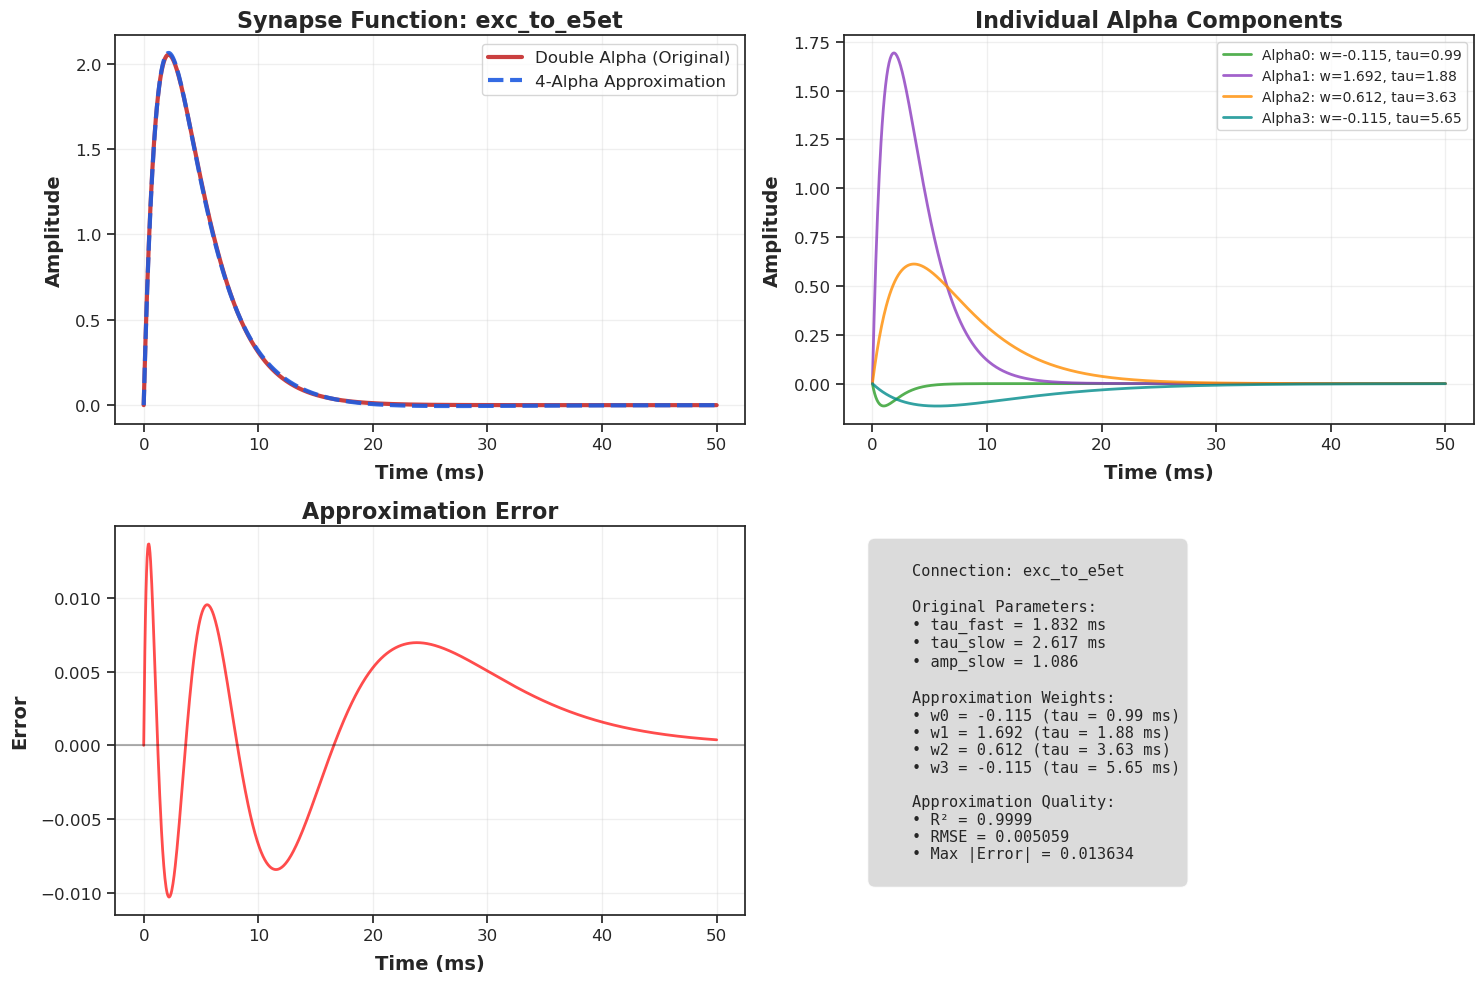

In [6]:
def plot_synapse_approximation(connection_name, figsize=(15, 10), t_max=50):
    """
    Plot comparison between double alpha function and 4-alpha approximation
    for a specific connection.
    """
    # Get parameters for this connection
    double_params = double_alpha_params[double_alpha_params['Unnamed: 0'] == connection_name].iloc[0]
    # basis_weights = basis_function_weights[basis_function_weights['Unnamed: 0'] == connection_name].iloc[0]
    basis_weights = basis_function_weights[basis_function_weights['connection_name'] == connection_name].iloc[0]
    
    tau_syn = double_params['tau_syn']
    tau_syn_slow = double_params['tau_syn_slow']
    amp_slow = double_params['amp_slow']
    
    weights = [basis_weights['w0'], basis_weights['w1'], basis_weights['w2'], basis_weights['w3']]
    
    # Time array
    t = np.linspace(0, t_max, 1000)
    
    # Compute functions
    double_alpha = double_alpha_function(t, tau_syn, tau_syn_slow, amp_slow)
    four_alpha_approx = basis_alpha_approximation(t, weights, tau_basis)
    
    # Individual alpha components
    alpha_components = []
    for i, (weight, tau) in enumerate(zip(weights, tau_basis)):
        alpha_components.append(weight * alpha_function(t, tau))
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    
    # Colors
    color_original = '#C52A2A'  # Red for original
    color_approx = '#1E5BE0'    # Blue for approximation
    color_components = ['#2A9D27', '#8B3BBF', '#FF8C00', '#008B8B']  # Different colors for components
    
    # Plot 1: Main comparison
    ax1.plot(t, double_alpha, linewidth=3, color=color_original, 
             label='Double Alpha (Original)', alpha=0.9)
    ax1.plot(t, four_alpha_approx, linewidth=3, color=color_approx, 
             linestyle='--', label='4-Alpha Approximation', alpha=0.9)
    ax1.set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Amplitude', fontsize=14, fontweight='bold')
    ax1.set_title(f'Synapse Function: {connection_name}', fontsize=16, fontweight='bold')
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(labelsize=12)
    
    # Plot 2: Individual alpha components
    for i, (component, tau_val, weight) in enumerate(zip(alpha_components, tau_basis, weights)):
        ax2.plot(t, component, linewidth=2, color=color_components[i], 
                 label=f'Alpha{i}: w={weight:.3f}, tau={tau_val:.2f}', alpha=0.8)
    ax2.set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Amplitude', fontsize=14, fontweight='bold')
    ax2.set_title('Individual Alpha Components', fontsize=16, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(labelsize=12)
    
    # Plot 3: Error analysis
    error = double_alpha - four_alpha_approx
    ax3.plot(t, error, linewidth=2, color='red', alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Error', fontsize=14, fontweight='bold')
    ax3.set_title('Approximation Error', fontsize=16, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(labelsize=12)
    
    # Calculate metrics
    mse = np.mean(error**2)
    rmse = np.sqrt(mse)
    max_abs_error = np.max(np.abs(error))
    r_squared = 1 - np.sum(error**2) / np.sum((double_alpha - np.mean(double_alpha))**2)
    
    # Plot 4: Statistics and parameters
    ax4.axis('off')
    stats_text = f"""
    Connection: {connection_name}
    
    Original Parameters:
    • tau_fast = {tau_syn:.3f} ms
    • tau_slow = {tau_syn_slow:.3f} ms  
    • amp_slow = {amp_slow:.3f}
    
    Approximation Weights:
    • w0 = {weights[0]:.3f} (tau = {tau_basis[0]:.2f} ms)
    • w1 = {weights[1]:.3f} (tau = {tau_basis[1]:.2f} ms)
    • w2 = {weights[2]:.3f} (tau = {tau_basis[2]:.2f} ms)
    • w3 = {weights[3]:.3f} (tau = {tau_basis[3]:.2f} ms)
    
    Approximation Quality:
    • R² = {r_squared:.4f}
    • RMSE = {rmse:.6f}
    • Max |Error| = {max_abs_error:.6f}
    """
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    return fig, (ax1, ax2, ax3, ax4), {'r_squared': r_squared, 'rmse': rmse, 'max_error': max_abs_error}

# Example usage
connection_name = 'exc_to_e5et'
fig, axes, metrics = plot_synapse_approximation(connection_name)
plt.show()

## Fitting double alpha functions to N-dimensional alpha basis

Development of a basis of N alpha functions to approximate all 121 double alpha functions using mean square error minimization over 30ms.

Computing all 121 double alpha functions...
Shape of all_functions: (121, 1000)
Time range: 0.000 to 30.000 ms
Number of time points: 1000


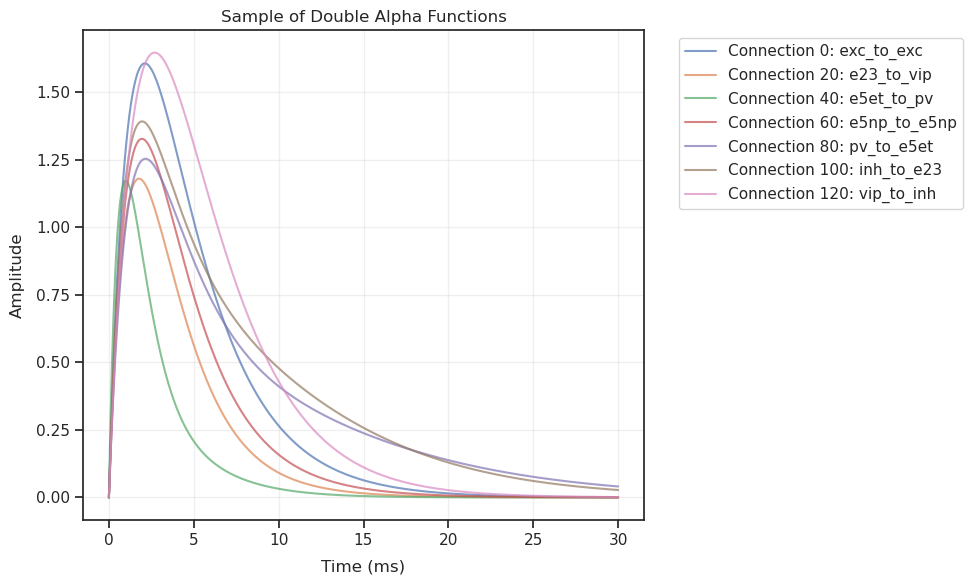

In [7]:
def compute_all_double_alpha_functions(double_alpha_params, t_max=30, n_points=1000):
    """
    Compute all 121 double alpha functions over the specified time range.
    """
    t = np.linspace(0, t_max, n_points)
    all_functions = np.zeros((len(double_alpha_params), n_points))
    
    for i, row in double_alpha_params.iterrows():
        tau_syn = row['tau_syn']
        tau_syn_slow = row['tau_syn_slow']
        amp_slow = row['amp_slow']
        all_functions[i] = double_alpha_function(t, tau_syn, tau_syn_slow, amp_slow)
    
    return t, all_functions

# Compute all double alpha functions
print("Computing all 121 double alpha functions...")
t, all_functions = compute_all_double_alpha_functions(double_alpha_params, t_max=30, n_points=1000)

print(f"Shape of all_functions: {all_functions.shape}")
print(f"Time range: {t[0]:.3f} to {t[-1]:.3f} ms")
print(f"Number of time points: {len(t)}")

# Visualize a few example functions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(0, len(double_alpha_params), 20):  # Every 20th function
    ax.plot(t, all_functions[i], alpha=0.7, label=f"Connection {i}: {double_alpha_params.iloc[i]['Unnamed: 0']}")

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude')
ax.set_title('Sample of Double Alpha Functions')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# perforom least squares optimization and return loss and optimized weights
def lstsq_optimization(tau_values, all_functions, t):
    """
    Calculate the mean loss (MSE) for a given set of tau values.
    
    Parameters:
    -----------
    tau_values : array
        Tau values for the alpha functions.
    all_functions : array
        All double alpha functions to approximate (shape: n_functions x n_timepoints).
    t : array
        Time vector.
    
    Returns:
    --------
    mean_loss : float
        Mean squared error across all functions.
    """
    n_dims = len(tau_values)
    n_functions = all_functions.shape[0]
    
    # Create design matrix for the given tau values
    design_matrix = np.zeros((len(t), n_dims))
    for j, tau in enumerate(tau_values):
        design_matrix[:, j] = alpha_function(t, tau)
    
    total_mse = 0
    all_weights = np.zeros((n_functions, n_dims))
    
    for i in range(n_functions):
        weights, _, _, _ = np.linalg.lstsq(design_matrix, all_functions[i], rcond=None)
        all_weights[i] = weights
        approx = basis_alpha_approximation(t, weights, tau_values)
        mse = np.mean((all_functions[i] - approx)**2)
        total_mse += mse
    
    mean_loss = total_mse / n_functions
    return mean_loss, all_weights

def find_optimal_n_alpha_basis(all_functions, t, n_dims, n_restarts=3):
    """
    Find optimal n-dimensional alpha basis using multiple initialization strategies.
    
    Parameters:
    -----------
    all_functions : array
        All double alpha functions to approximate (shape: n_functions x n_timepoints)
    t : array
        Time vector
    n_dims : int
        Number of alpha functions in the basis
    n_restarts : int
        Number of different initialization strategies to try
    """
    # Analyze the tau parameters in the original double alpha functions
    tau_fast = double_alpha_params['tau_syn'].values
    tau_slow = double_alpha_params['tau_syn_slow'].values
    
    all_tau_values = np.concatenate([tau_fast, tau_slow])
    n_functions = len(all_functions)
    
    best_result = None
    best_loss = np.inf
    
    # Create different initialization strategies
    tau_init_strategies = []
    
    # Strategy 1: Evenly spaced quantiles
    quantiles = np.linspace(0, 100, n_dims + 2)[1:-1]  # Exclude 0 and 100
    tau_init_strategies.append(np.percentile(all_tau_values, quantiles))
    
    # Strategy 2: Log-spaced values
    min_tau, max_tau = all_tau_values.min(), all_tau_values.max()
    tau_init_strategies.append(np.logspace(np.log10(min_tau), np.log10(max_tau), n_dims))
    
    # Strategy 3: Random sampling from existing values (if enough restarts)
    if n_restarts > 2:
        for _ in range(n_restarts - 2):
            tau_init_strategies.append(np.sort(np.random.choice(all_tau_values, n_dims, replace=False)))
    
    results = []
    
    for strategy_idx, tau_init in enumerate(tau_init_strategies):
        print(f"  Strategy {strategy_idx + 1}: tau = {tau_init}")

        avg_mse, all_weights = lstsq_optimization(tau_init, all_functions, t)
        print(f"    Average MSE: {avg_mse:.6f}")
        
        results.append({
            'tau_basis': np.array(tau_init),
            'weights': all_weights,
            'avg_mse': avg_mse,
        })
        
        if avg_mse < best_loss:
            best_loss = avg_mse
            best_result = results[-1]
    
    # Fine-tune the best result by optimizing tau values slightly
    print(f"  Fine-tuning best result (initial MSE: {best_result['avg_mse']:.6f})...")
    
    def objective_function(tau_params):
        # Objective function to minimize average MSE by adjusting tau values only
        avg_mse, all_weights = lstsq_optimization(tau_params, all_functions, t)
        return avg_mse
    
    # Optimize tau values with bounds
    bounds = [(0.1, 15.0)] * n_dims  # Reasonable bounds for tau values
    
    result = minimize(objective_function, best_result['tau_basis'], 
                     method='L-BFGS-B', bounds=bounds)
    
    if result.success and result.fun < best_result['avg_mse']:
        print(f"  Fine-tuning improved MSE to: {result.fun:.6f}")
        optimal_tau = result.x
    else:
        print("  Fine-tuning did not improve the result, keeping original.")
        optimal_tau = best_result['tau_basis']
    
    # Recompute weights with optimal tau
    final_avg_mse, final_weights = lstsq_optimization(optimal_tau, all_functions, t)
    
    # Calcute mse for each connection type
    mse_per_function = np.zeros(n_functions)
    for i in range(n_functions):
        approx = basis_alpha_approximation(t, final_weights[i], tau_basis)
        mse_per_function[i] = np.mean((all_functions[i] - approx)**2)

    return {
        'tau_basis': optimal_tau,
        'weights': final_weights,
        'avg_mse': final_avg_mse,
        'mse_per_function': mse_per_function,
        'n_dims': n_dims,
        'all_results': results
    }

# Perform analysis for different dimensions
dimensions_to_test = [2, 3, 4, 5]
multi_dim_results = {}

print("Performing multi-dimensional alpha basis analysis...")
print("="*60)

for n_dims in dimensions_to_test:
    print(f"\\nAnalyzing {n_dims}-dimensional alpha basis...")
    result = find_optimal_n_alpha_basis(all_functions, t, n_dims, n_restarts=3)
    multi_dim_results[n_dims] = result
    
    print(f"Final result for {n_dims}D: avg_MSE = {result['avg_mse']:.8f}")
    print(f"Tau values: {result['tau_basis']}")

print("\\n" + "="*60)
print("Multi-dimensional analysis completed!")

Performing multi-dimensional alpha basis analysis...
\nAnalyzing 2-dimensional alpha basis...
  Strategy 1: tau = [1.75201531 2.90322057]
    Average MSE: 0.006920
  Strategy 2: tau = [0.7579732  7.23813909]
    Average MSE: 0.063635
  Strategy 3: tau = [1.27579767 1.50304465]
    Average MSE: 0.022928
  Fine-tuning best result (initial MSE: 0.006920)...
  Fine-tuning improved MSE to: 0.003304
Final result for 2D: avg_MSE = 0.00330447
Tau values: [1.73670336 4.94707108]
\nAnalyzing 3-dimensional alpha basis...
  Strategy 1: tau = [1.67774841 2.21493465 3.16928913]
    Average MSE: 0.001572
  Strategy 2: tau = [0.7579732  2.34228851 7.23813909]
    Average MSE: 0.000835
  Strategy 3: tau = [1.71394429 5.98649332 6.16135206]
    Average MSE: 0.001628
  Fine-tuning best result (initial MSE: 0.000835)...
  Fine-tuning improved MSE to: 0.000304
Final result for 3D: avg_MSE = 0.00030416
Tau values: [1.1304584  2.32280653 6.10961287]
\nAnalyzing 4-dimensional alpha basis...
  Strategy 1: tau 

In [9]:
def create_summary_dataframe(results, all_functions, t, dimensions_to_test):
    """
    Create a summary DataFrame from multi-dimensional alpha basis results.
    
    Parameters
    ----------
    results : dict
        Dictionary containing results for each dimension
    all_functions : np.ndarray
        Original functions to compare against (shape: n_functions x n_timepoints)
    t : np.ndarray
        Time vector
    dimensions_to_test : list
        List of dimensions to include in summary
    
    Returns
    -------
    pd.DataFrame
        Summary statistics for each dimension
    """
    summary_data = []
    
    for n_dims in dimensions_to_test:
        result = results[n_dims]
        
        # Compute R² statistics
        r2_scores = []
        for i in range(len(all_functions)):
            original = all_functions[i]
            approx = basis_alpha_approximation(t, result['weights'][i], result['tau_basis'])
            r2 = r2_score(original, approx)
            r2_scores.append(r2)
        
        excellent = np.sum(np.array(r2_scores) > 0.99)
        good = np.sum((np.array(r2_scores) > 0.95) & (np.array(r2_scores) <= 0.99))
        
        summary_data.append({
            'dimension': n_dims,
            'avg_mse': result['avg_mse'],
            'mean_r2': np.mean(r2_scores),
            'excellent_count': excellent,
            'good_count': good,
            'excellent_percent': 100 * excellent / len(all_functions),
            'tau_values': ', '.join([f'{tau:.3f}' for tau in result['tau_basis']])
        })
    
    return pd.DataFrame(summary_data)

# Create and display summary
summary_df = create_summary_dataframe(multi_dim_results, all_functions, t, dimensions_to_test)

print("\nSummary of all dimensions:")
print(summary_df.to_string(index=False))


Summary of all dimensions:
 dimension  avg_mse  mean_r2  excellent_count  good_count  excellent_percent                        tau_values
         2 0.003304 0.975970               57          45          47.107438                      1.737, 4.947
         3 0.000304 0.998149              117           4          96.694215               1.130, 2.323, 6.110
         4 0.000041 0.999753              121           0         100.000000        0.998, 1.913, 3.748, 5.576
         5 0.000008 0.999939              121           0         100.000000 0.758, 1.332, 2.342, 4.118, 7.238


In [10]:
# Enhanced optimization methods for better fitting
def enhanced_alpha_approximation_optimizer(all_functions, t, n_dims, max_iterations=50):
    """
    Enhanced optimization for alpha function basis with multiple advanced strategies.
    
    Uses:
    1. Global optimization with differential evolution
    2. Basin hopping for escaping local minima
    3. Multi-start optimization with smart initialization
    4. Adaptive parameter bounds based on data characteristics
    """
    
    # Analyze the tau parameters in the original double alpha functions
    tau_fast = double_alpha_params['tau_syn'].values
    tau_slow = double_alpha_params['tau_syn_slow'].values
    all_tau_values = np.concatenate([tau_fast, tau_slow])
    
    min_tau, max_tau = 0.1, 15.0  # Conservative bounds
    n_functions = all_functions.shape[0]
    
    def objective_function(tau_params):
        # Objective function to minimize average MSE by adjusting tau values only
        avg_mse, all_weights = lstsq_optimization(tau_params, all_functions, t)
        return avg_mse
        
    ### Strategy 1: Differential Evolution (Global optimization) ###
    print("    Strategy 1: Differential Evolution...")
    bounds = [(min_tau, max_tau)] * n_dims
    
    de_result = differential_evolution(
        objective_function, 
        bounds, 
        maxiter=1000, 
        popsize=15,
        atol=1e-8,
        seed=42,
        workers=1
    )
    
    best_result = {
        'tau_basis': np.sort(de_result.x),
        'mse': de_result.fun,
        'method': 'Differential Evolution'
    }
    
    print(f"      DE result: MSE = {de_result.fun:.8f}")
    
    ### Strategy 2: Basin Hopping with multiple starting points ###
    print("    Strategy 2: Basin Hopping...")
    
    # Smart initialization based on data quantiles
    quantiles = np.linspace(5, 95, n_dims)
    smart_init = np.percentile(all_tau_values, quantiles)
    
    # def basin_hop_callback(x, f, accept):
    #     if f < best_result['mse']:
    #         print(f"      New best from Basin Hopping: MSE = {f:.8f}")
    
    bh_result = basinhopping(
        objective_function,
        smart_init,
        niter=300,
        T=0.01,
        stepsize=0.5,
        minimizer_kwargs={
            'method': 'L-BFGS-B',
            'bounds': bounds
        },
        # callback=basin_hop_callback,
        seed=42
    )
    
    if bh_result.fun < best_result['mse']:
        best_result = {
            'tau_basis': np.sort(bh_result.x),
            'mse': bh_result.fun,
            'method': 'Basin Hopping'
        }
        print(f"      Basin Hopping improved to: MSE = {bh_result.fun:.8f}")
    
    ### Strategy 3: Multi-start L-BFGS-B with smart initializations ###
    print("    Strategy 3: Multi-start optimization...")
    
    initialization_strategies = [
        np.logspace(np.log10(min_tau), np.log10(max_tau), n_dims),  # Log-spaced
        np.linspace(min_tau, max_tau, n_dims),  # Linear
        np.percentile(all_tau_values, np.linspace(10, 90, n_dims)),  # Data-driven
        np.sort(np.random.uniform(min_tau, max_tau, n_dims)),  # Random 1
        np.sort(np.random.uniform(min_tau, max_tau, n_dims)),  # Random 2
    ]
    
    for i, init in enumerate(initialization_strategies):
        result = minimize(
            objective_function,
            init,
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 200, 'ftol': 1e-10}
        )
        
        if result.success and result.fun < best_result['mse']:
            best_result = {
                'tau_basis': np.sort(result.x),
                'mse': result.fun,
                'method': f'Multi-start #{i+1}'
            }
            print(f"      Multi-start #{i+1} improved to: MSE = {result.fun:.8f}")
    
    ### Final refinement with very tight tolerances ###
    print("    Final refinement...")
    final_result = minimize(
        objective_function,
        best_result['tau_basis'],
        method='L-BFGS-B',
        bounds=bounds,
        options={
            'maxiter': 5000,
            'ftol': 1e-12,
            'gtol': 1e-12
        }
    )
    
    if final_result.success and final_result.fun < best_result['mse']:
        best_result = {
            'tau_basis': np.sort(final_result.x),
            'mse': final_result.fun,
            'method': 'Final Refinement'
        }
        print(f"      Final refinement improved to: MSE = {final_result.fun:.8f}")
    
    # Compute final weights and detailed metrics with optimal tau
    optimal_tau = best_result['tau_basis']
    final_avg_mse, final_weights = lstsq_optimization(optimal_tau, all_functions, t)
    
    
    mse_per_function = np.zeros(n_functions)
    r2_per_function = np.zeros(n_functions)
    
    for i in range(n_functions):
        weights = final_weights[i]
        
        # Compute approximation        
        approx = basis_alpha_approximation(t, weights, optimal_tau)
        mse_per_function[i] = np.mean((all_functions[i] - approx)**2)
        
        # Compute the R² score
        r2 = 1 - np.sum((all_functions[i] - approx)**2) / np.sum((all_functions[i] - np.mean(all_functions[i]))**2)
        r2_per_function[i] = r2
    
    print(f"    Final tau values: {optimal_tau}")
    print(f"    Best method: {best_result['method']}")
    print(f"    Final MSE: {best_result['mse']:.8f}")
    print(f"    Mean R²: {np.mean(r2_per_function):.6f}")
    
    return {
        'tau_basis': optimal_tau,
        'weights': final_weights,
        'avg_mse': best_result['mse'],
        'mse_per_function': mse_per_function,
        'r2_per_function': r2_per_function,
        'mean_r2': np.mean(r2_per_function),
        'n_dims': n_dims,
        'optimization_method': best_result['method']
    }

In [11]:
# Apply enhanced optimization for multiple dimensions
print("ENHANCED MULTI-DIMENSIONAL ALPHA BASIS OPTIMIZATION")
print("=" * 70)
print("Using advanced optimization strategies:")
print("• Differential Evolution for global search")
print("• Basin Hopping for escaping local minima") 
print("• Multi-start optimization with smart initialization")
print("• Regularization for numerical stability")
print("=" * 70)

# Test dimensions from 2 to 7 for comprehensive analysis
enhanced_dimensions = [2, 3, 4, 5]#, 6, 7]
enhanced_results = {}

for n_dims in enhanced_dimensions:
    print(f"\nOptimizing {n_dims}-dimensional alpha basis...")
    print("-" * 50)
    
    result = enhanced_alpha_approximation_optimizer(all_functions, t, n_dims)
    enhanced_results[n_dims] = result

print("\n" + "=" * 70)
print("ENHANCED OPTIMIZATION SUMMARY")
print("=" * 70)

# Find the best dimension based on different criteria
best_mse_dim = min(enhanced_results.keys(), key=lambda k: enhanced_results[k]['avg_mse'])
best_r2_dim = max(enhanced_results.keys(), key=lambda k: enhanced_results[k]['mean_r2'])

print(f"\nBest MSE: {enhanced_results[best_mse_dim]['avg_mse']:.8f} ({best_mse_dim}D)")
print(f"Best R²: {enhanced_results[best_r2_dim]['mean_r2']:.6f} ({best_r2_dim}D)")

print(f"\nDetailed Results:")
for n_dims in enhanced_dimensions:
    result = enhanced_results[n_dims]
    print(f"{n_dims}D: MSE={result['avg_mse']:.8f}, R²={result['mean_r2']:.6f}, Method={result['optimization_method']}")

# Analyze improvement over baseline
if 'multi_dim_results' in globals() and len(multi_dim_results) > 0:
    print(f"\nImprovement Analysis:")
    for n_dims in enhanced_dimensions:
        if n_dims in multi_dim_results:
            old_mse = multi_dim_results[n_dims]['avg_mse']
            new_mse = enhanced_results[n_dims]['avg_mse']
            improvement = (old_mse - new_mse) / old_mse * 100
            print(f"{n_dims}D: {improvement:.2f}% improvement in MSE")

print("=" * 70)

# Create and display summary
summary_df = create_summary_dataframe(enhanced_results, all_functions, t, dimensions_to_test)

print("\nSummary of all dimensions:")
print(summary_df.to_string(index=False))

# # Save enhanced 4D tau_basis and basis_function_weights
# save_path_tau = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/synaptic_data/tau_basis_enhanced_4.npy'
# save_path_weights = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/synaptic_data/basis_function_weights_enhanced_4.csv'

# # Save tau_basis
# np.save(save_path_tau, enhanced_results[4]['tau_basis'])

# # Save weights with connection names
# weights_df = pd.DataFrame(enhanced_results[4]['weights'], columns=['w0', 'w1', 'w2', 'w3'])
# weights_df.insert(0, 'connection_name', double_alpha_params['Unnamed: 0'].values)
# weights_df.to_csv(save_path_weights, index=False)

# print(f"Saved tau_basis to: {save_path_tau}")
# print(f"Saved basis_function_weights to: {save_path_weights}")
# print("First few rows of weights:")
# print(weights_df.head())

ENHANCED MULTI-DIMENSIONAL ALPHA BASIS OPTIMIZATION
Using advanced optimization strategies:
• Differential Evolution for global search
• Basin Hopping for escaping local minima
• Multi-start optimization with smart initialization
• Regularization for numerical stability

Optimizing 2-dimensional alpha basis...
--------------------------------------------------
    Strategy 1: Differential Evolution...
      DE result: MSE = 0.00330447
    Strategy 2: Basin Hopping...
      Basin Hopping improved to: MSE = 0.00330447
    Strategy 3: Multi-start optimization...
    Final refinement...
      Final refinement improved to: MSE = 0.00330447
    Final tau values: [1.73681463 4.94892913]
    Best method: Final Refinement
    Final MSE: 0.00330447
    Mean R²: 0.975973

Optimizing 3-dimensional alpha basis...
--------------------------------------------------
    Strategy 1: Differential Evolution...
      DE result: MSE = 0.00030417
    Strategy 2: Basin Hopping...
      Basin Hopping improved

## Basis functions figures

Creating boxplot analysis...


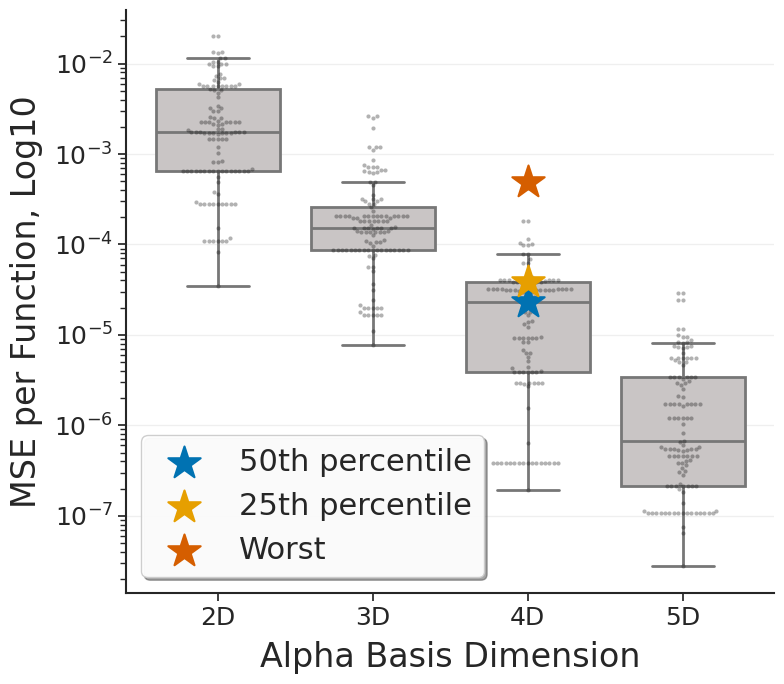

In [37]:
def create_boxplot_mse_analysis(multi_dim_results, dimensions_to_test):
    """
    Create modern styled boxplot figure showing MSE distributions for each basis dimension.
    """
    # Prepare data for seaborn boxplot
    plot_data = []
    for n_dims in dimensions_to_test:
        mse_per_func = multi_dim_results[n_dims]['mse_per_function']
        for mse in mse_per_func:
            plot_data.append({
                'Dimension': f'{n_dims}D',
                'MSE': mse,
                'n_dims': n_dims
            })
    
    plot_df = pd.DataFrame(plot_data)

    # Find examples for the 4D case
    n_dims = 4
    best_idx = np.argmin(multi_dim_results[n_dims]['mse_per_function'])
    worst_idx = np.argmax(multi_dim_results[n_dims]['mse_per_function'])
    
    # Find a couple of intermediate examples
    sorted_indices = np.argsort(multi_dim_results[n_dims]['mse_per_function'])
    n_total = len(sorted_indices)
    
    # Select examples: 50th percentile, 25th percentile, Worst
    examples = {
        '50th percentile': sorted_indices[n_total//2],
        '25th percentile': sorted_indices[3*n_total//4], 
        'Worst': worst_idx
    }

    # Get MSE values for these examples
    example_mse_values = {
        '50th percentile': multi_dim_results[n_dims]['mse_per_function'][examples['50th percentile']],
        '25th percentile': multi_dim_results[n_dims]['mse_per_function'][examples['25th percentile']],
        'Worst': multi_dim_results[n_dims]['mse_per_function'][examples['Worst']]
    }
    
    # Color scheme for examples
    example_colors = {
        '50th percentile': '#0072B2',    # Blue  
        '25th percentile': '#E69F00',    # Orange
        'Worst': '#D55E00'    # Red
    }
    
    # Create figure with modern styling
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 7))
    
    # Modern color palette for boxplot
    box_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C']
    
    # Plot boxplot
    sns.boxplot(data=plot_df, x='Dimension', y='MSE', ax=ax1, 
                color="#CAC4C4", linewidth=2, fliersize=0)  # fliersize=0 to hide outliers
    
    # Overlay swarmplot
    sns.swarmplot(data=plot_df, x='Dimension', y='MSE', ax=ax1,
                  color='black', alpha=0.3, size=3)
    
    # Add stars for the specific examples in 4D
    # Find the x-position for 4D (which is the index in dimensions_to_test)
    dim_4d_idx = dimensions_to_test.index(4)
    
    for example_name, mse_value in example_mse_values.items():
        ax1.scatter(dim_4d_idx, mse_value, 
                   marker='*', s=600, 
                   color=example_colors[example_name],
                   edgecolors=example_colors[example_name], linewidths=1.5,
                   zorder=10,
                   label=example_name)
    
    ax1.set_xlabel('Alpha Basis Dimension', fontsize=24)
    ax1.set_ylabel('MSE per Function, Log10', fontsize=24)
    # ax1.set_title('MSE Distribution by Basis Dimension', fontsize=22, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(labelsize=18)
    
    # Add legend for the stars
    ax1.legend(fontsize=22, loc='lower left', frameon=True, 
               fancybox=True, shadow=True, framealpha=0.95)
    
    # Remove top and right spines for cleaner look
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(1.5)
    ax1.spines['bottom'].set_linewidth(1.5)
    
    plt.tight_layout()
    return fig

# Create the analysis figures
print("Creating boxplot analysis...")
boxplot_fig = create_boxplot_mse_analysis(enhanced_results, dimensions_to_test)
boxplot_fig.savefig('synaptic_data/alpha_basis_mse_analysis.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


Creating 3D 4D examples showcase...


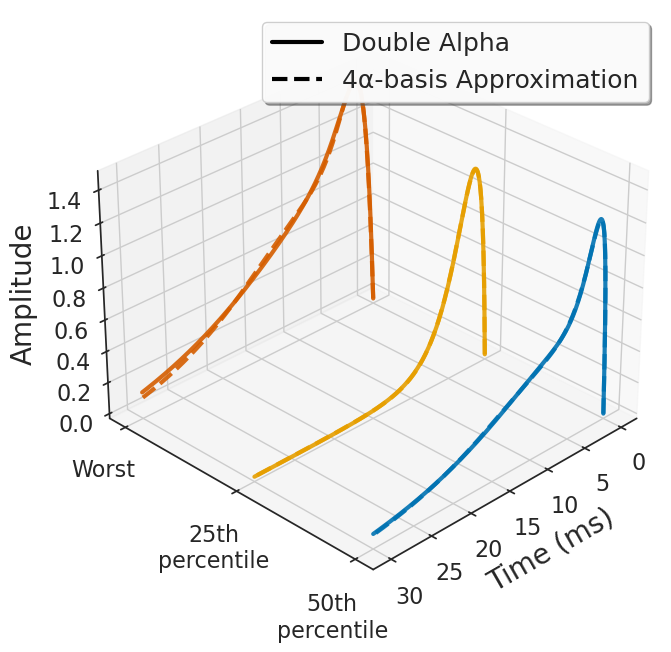

In [ ]:
def create_quality_examples_showcase_3d(enhanced_results, all_functions, t, double_alpha_params, n_dims=4):
    """
    Create a 3D figure showcasing best, worst, and additional examples for 4D approximation.
    Uses depth (z-axis) to separate different quality levels.
    """
    # Help static type checkers (Pylance) understand this is a 3D axes
    from typing import cast
    from mpl_toolkits.mplot3d.axes3d import Axes3D
    
    results_dimension = enhanced_results[n_dims]
    
    # Pick representative examples
    sorted_indices = np.argsort(results_dimension['mse_per_function'])
    n_total = len(sorted_indices)
    worst_idx = np.argmax(results_dimension['mse_per_function'])
    examples = {
        '50th percentile': sorted_indices[n_total // 2],
        '25th percentile': sorted_indices[n_total // 4],
        'Worst': worst_idx,
    }
    
    # Figure
    fig = plt.figure(figsize=(8, 8))
    ax = cast(Axes3D, fig.add_subplot(111, projection='3d'))
    
    colors = {
        '50th percentile': '#0072B2',
        '25th percentile': '#E69F00',
        'Worst': '#D55E00',
    }
    line_styles = {'Original': '-', 'Approximation': '--'}
    z_positions = {'50th percentile': 2, '25th percentile': 1, 'Worst': 0}
    
    for quality, idx in examples.items():
        original_func = all_functions[idx]
        approx_func = basis_alpha_approximation(
            t, results_dimension['weights'][idx], results_dimension['tau_basis']
        )
        z_pos = z_positions[quality]
        z_array = np.full_like(t, z_pos)
        
        ax.plot(
            t, z_array, original_func,
            color=colors[quality], linewidth=3, linestyle=line_styles['Original'], alpha=0.9,
        )
        ax.plot(
            t, z_array, approx_func,
            color=colors[quality], linewidth=3, linestyle=line_styles['Approximation'], alpha=0.9,
        )
    
    # Labels
    ax.set_xlabel('Time (ms)', fontsize=20, labelpad=12)
    # ax.set_ylabel('Quality Level', fontsize=20, labelpad=28)
    
    # Matplotlib 3D z-labels are prone to being clipped; place it as a rotated 2D overlay
    ax.set_zlabel('')
    ax.text2D(
        -0.1, 0.4, 'Amplitude',
        transform=ax.transAxes, ha='left', va='top', fontsize=20,
        rotation=90, rotation_mode='anchor'
    )
    
    # Move y-label slightly left to avoid overlapping tick labels
    try:
        ax.yaxis.set_label_coords(-0.14, 0.5)
    except Exception:
        pass
    
    # Y ticks (add padding so they don't collide with the y-label)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Worst', '25th\npercentile', '50th\npercentile'], fontsize=16)
    ax.tick_params(axis='y', pad=10)
    ax.tick_params(axis='x', labelsize=16, pad=6)
    ax.tick_params(axis='z', labelsize=16, pad=6)
    
    # Legend (line style meaning)
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=3, linestyle='-', label='Double Alpha'),
        Line2D([0], [0], color='black', linewidth=3, linestyle='--', label='4α-basis Approximation'),
    ]
    ax.legend(
        handles=legend_elements, loc='upper right', fontsize=18,
        frameon=True, fancybox=True, shadow=True, framealpha=0.95,
    )
    
    ax.grid(True, alpha=0.25)
    
    # Keep the view you liked
    ax.view_init(elev=30, azim=45)
    
    # IMPORTANT: for 3D, prefer explicit margins over tight_layout
    fig.subplots_adjust(left=0.16, right=0.90, bottom=0.06, top=0.98)
    
    return fig
    

print("Creating 3D 4D examples showcase...")
showcase_3d_fig = create_quality_examples_showcase_3d(enhanced_results, all_functions, t, double_alpha_params, n_dims=4)
plt.show()

Creating stacked 2D quality examples showcase...


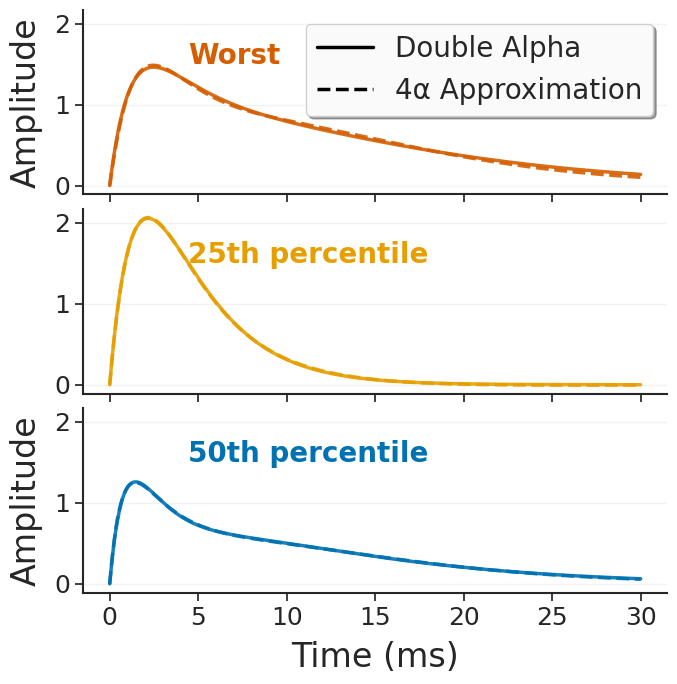

In [36]:
def create_quality_examples_showcase_2d(enhanced_results, all_functions, t, double_alpha_params, n_dims=4):
    """
    Create a stacked 2D figure showcasing quality examples for the alpha basis approximation.
    Three vertically stacked subplots: Worst, 25th percentile, 50th percentile.
    """
    results_dimension = enhanced_results[n_dims]
    
    # Pick representative examples
    sorted_indices = np.argsort(results_dimension['mse_per_function'])
    n_total = len(sorted_indices)
    worst_idx = np.argmax(results_dimension['mse_per_function'])
    
    # Order: Worst (top), 25th percentile (middle), 50th percentile (bottom)
    examples = [
        ('Worst', worst_idx),
        ('25th percentile', sorted_indices[3 * n_total // 4]),
        ('50th percentile', sorted_indices[n_total // 2]),
    ]
    
    colors = {
        'Worst': '#D55E00',
        '25th percentile': '#E69F00',
        '50th percentile': '#0072B2',
    }
    
    # Create figure with shared axes
    fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True, sharey=True)
    
    for ax, (quality, idx) in zip(axes, examples):
        original_func = all_functions[idx]
        approx_func = basis_alpha_approximation(
            t, results_dimension['weights'][idx], results_dimension['tau_basis']
        )
        
        # Plot original (solid) and approximation (dashed)
        ax.plot(t, original_func, color=colors[quality], linewidth=2.5, 
                linestyle='-', alpha=0.9, label='Double Alpha')
        ax.plot(t, approx_func, color=colors[quality], linewidth=2.5, 
                linestyle='--', alpha=0.9, label='4α-basis Approximation')
        
        # Label on the right side
        ax.text(0.18, 0.75, quality, transform=ax.transAxes, fontsize=20,
                va='center', ha='left', fontweight='bold', color=colors[quality])
        
        # Styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.tick_params(labelsize=18)
        ax.grid(True, alpha=0.25, axis='y')
    
    # Common labels
    axes[-1].set_xlabel('Time (ms)', fontsize=24)
    axes[0].set_ylabel('Amplitude', fontsize=24)
    axes[2].set_ylabel('Amplitude', fontsize=24)
    
    # Single legend at the top
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=2.5, linestyle='-', label='Double Alpha'),
        Line2D([0], [0], color='black', linewidth=2.5, linestyle='--', label='4α Approximation'),
    ]
    axes[0].legend(handles=legend_elements, loc='upper right', fontsize=20, ncol=1,
                   frameon=True, fancybox=True, shadow=True, framealpha=0.95)
    
    plt.tight_layout()
    fig.subplots_adjust(left=0.12, right=0.85, hspace=0.08)

    plt.savefig('synaptic_data/alpha_basis_examples.png', dpi=300, bbox_inches='tight', transparent=True)

    return fig

print("Creating stacked 2D quality examples showcase...")
showcase_2d_fig = create_quality_examples_showcase_2d(enhanced_results, all_functions, t, double_alpha_params, n_dims=4)
plt.show()

Creating 4-alpha basis functions plot...


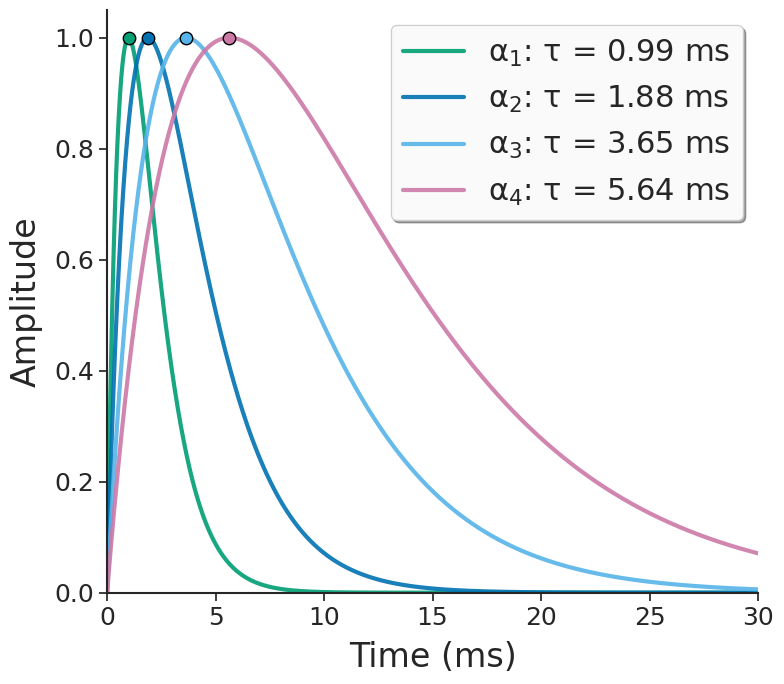

In [35]:
def plot_alpha_basis_functions(enhanced_results, n_dims=4, t_max=30, save_path=None):
    """
    Create a publication-quality plot of the alpha basis functions for a given dimension.
    
    Parameters:
    -----------
    enhanced_results : dict
        Results from enhanced optimization containing tau values
    n_dims : int
        Dimension of alpha basis to plot (default: 4)
    t_max : float
        Maximum time to plot (default: 30 ms)
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    # Get the tau basis for the specified dimension
    tau_basis = enhanced_results[n_dims]['tau_basis']
    
    # Create time vector with high resolution for smooth curves
    t = np.linspace(0, t_max, 2000)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Color palette for the basis functions
    colors = ['#009E73', '#0072B2', '#56B4E9', '#CC79A7', '#9B59B6', '#1ABC9C', '#E67E22']
    
    # Plot each alpha basis function
    for i, tau in enumerate(tau_basis):
        alpha_func = alpha_function(t, tau)
        ax.plot(t, alpha_func, linewidth=3, color=colors[i % len(colors)], 
                label=f'α$_{{{i+1}}}$: τ = {tau:.2f} ms', alpha=0.9)
        
        # Add peak marker
        peak_time = tau  # Peak occurs at t = tau for alpha function
        # peak_value = alpha_function(peak_time, tau)
        peak_value = alpha_function(np.array([peak_time]), tau)[0]
        ax.scatter(peak_time, peak_value, color=colors[i % len(colors)], 
                  s=80, zorder=10, edgecolor='black', linewidth=1)
    
    # Customize the plot
    ax.set_xlabel('Time (ms)', fontsize=24)
    ax.set_ylabel('Amplitude', fontsize=24)
    # ax.set_title(f'{n_dims}-Alpha Basis Functions', fontsize=26, fontweight='bold', pad=20)

    # Configure legend
    ax.legend(loc='upper right', fontsize=22, frameon=True, ncol=1,
              fancybox=True, shadow=True, framealpha=0.95)
    
    # Grid and styling
    # ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.tick_params(labelsize=18)
    
    # Set reasonable limits
    ax.set_xlim(0, t_max)
    ax.set_ylim(0, 1.05)  # Alpha functions are normalized to peak at 1
    
    plt.tight_layout()
    
    # Save if path provided
    # if save_path is not None:
    # print actual path
    plt.savefig('synaptic_data/alpha_basis_functions.png', dpi=300, bbox_inches='tight', transparent=True)
    
    return fig, ax

# Create the 4-alpha basis functions plot
print("Creating 4-alpha basis functions plot...")
basis_fig, basis_ax = plot_alpha_basis_functions(enhanced_results, n_dims=4,
                                                save_path='4_alpha_basis_functions.png')
plt.show()

In [ ]:
# Estimate the error in the approximation based on the total area under the curve for the worst examples, relative to the total area
def estimate_approximation_error(all_functions, approximations):
    """
    Estimate the error in the approximation based on the total area under the curve.
    
    Parameters:
    -----------
    all_functions : array
        Original functions (shape: n_functions x n_timepoints)
    approximations : array
        Approximated functions (shape: n_functions x n_timepoints)
    
    Returns:
    --------
    error_estimate : float
        Estimated error as a percentage of the total area.
    """
    total_area_original = np.sum(all_functions, axis=1) 
    total_area_approx = np.sum(approximations, axis=1)
    
    # Calculate absolute error for each function
    absolute_error = np.abs(total_area_original - total_area_approx)
    
    # Estimate error as a percentage of the original area
    error_estimate = np.max(absolute_error / np.abs(total_area_original)) * 100
    
    return error_estimate

# Estimate the approximation error for the 4D results
result_4d = enhanced_results[4]
approximation_error = estimate_approximation_error(all_functions,
                                                   np.array([basis_alpha_approximation(t,
                                                                 result_4d['weights'][i],
                                                                 result_4d['tau_basis'])
                                                             for i in range(len(all_functions))]))
print(f"Estimated approximation error for 4D basis: {approximation_error:.2f}%")

Estimated approximation error for 4D basis: 1.58%



Creating multi-dimensional basis functions comparison...


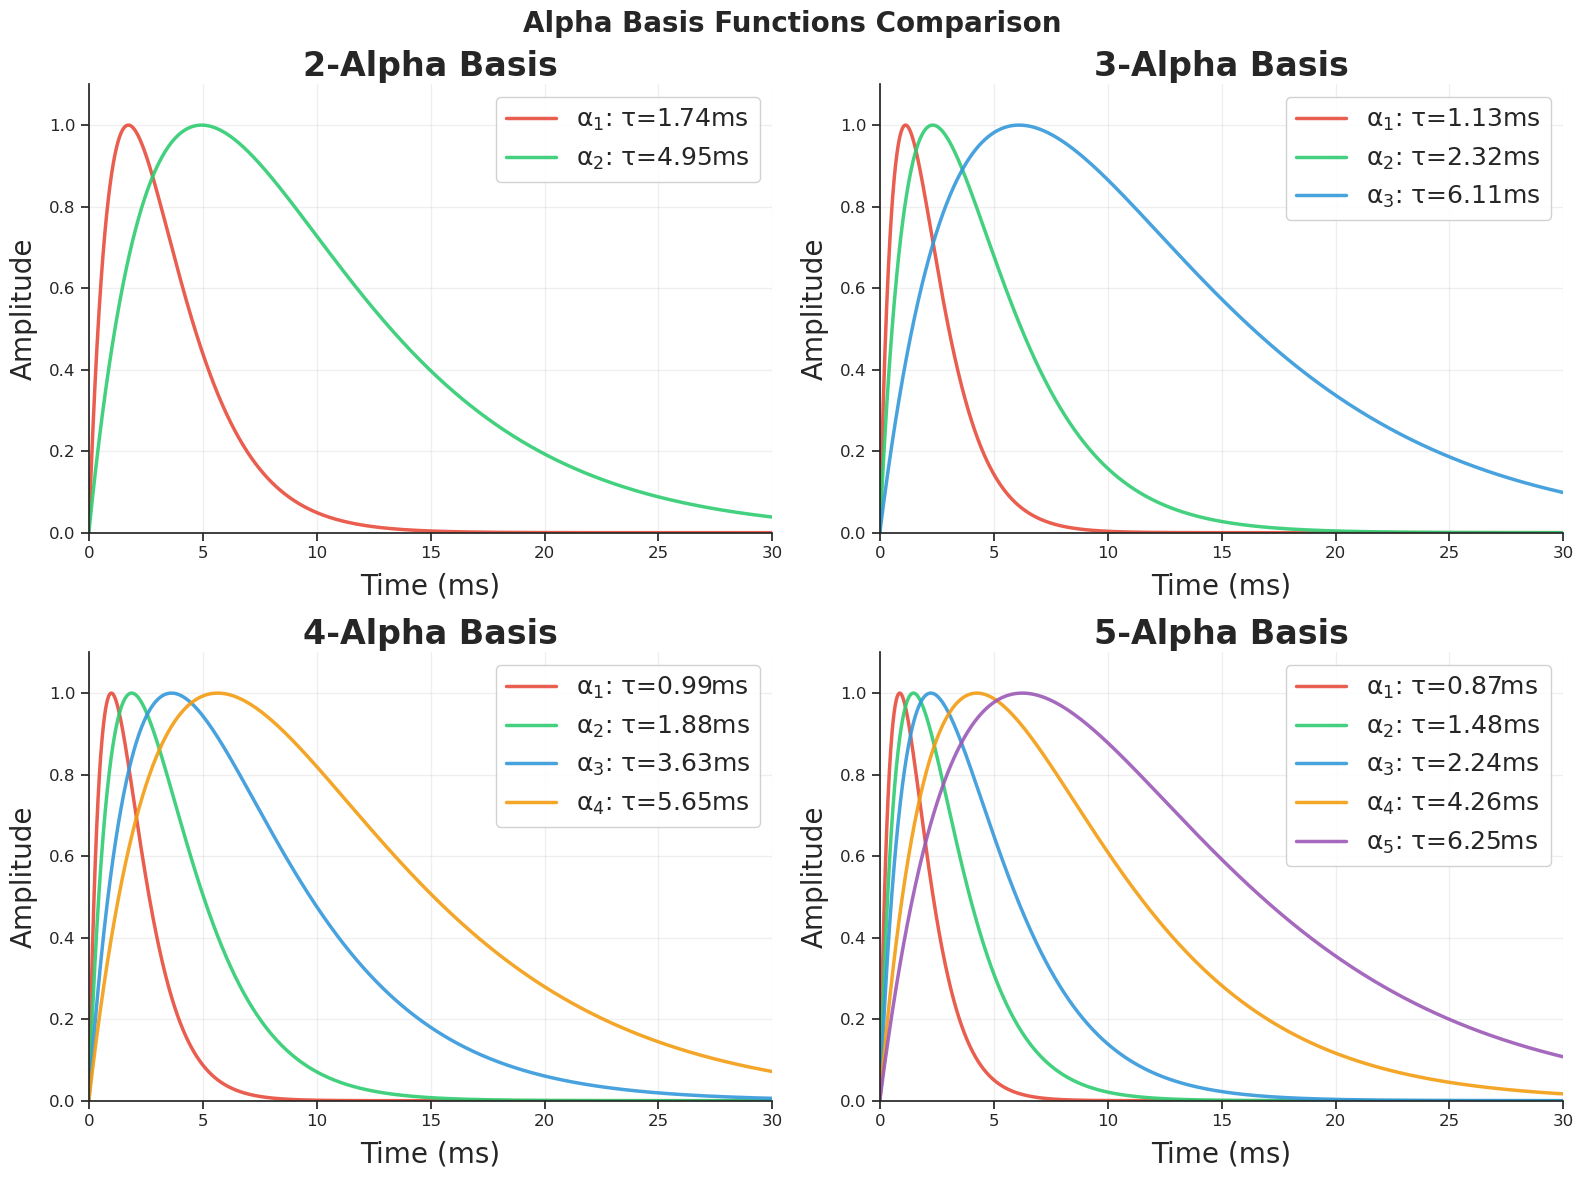

In [ ]:
def plot_alpha_basis_comparison(enhanced_results, dimensions=[2, 3, 4, 5], 
                               t_max=30, save_path=None):
    """
    Create a comparison plot of alpha basis functions for different dimensions.
    
    Parameters:
    -----------
    enhanced_results : dict
        Results from enhanced optimization containing tau values
    dimensions : list
        List of dimensions to compare (default: [2, 3, 4, 5])
    t_max : float
        Maximum time to plot (default: 30 ms)
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes
    """
    # Create subplots
    n_dims = len(dimensions)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Color palette
    colors = ['#E74C3C', '#2ECC71', '#3498DB', '#F39C12', '#9B59B6', '#1ABC9C', '#E67E22']
    
    # Time vector
    t = np.linspace(0, t_max, 2000)
    
    for idx, dim in enumerate(dimensions):
        ax = axes[idx]
        tau_basis = enhanced_results[dim]['tau_basis']
        
        # Plot each alpha function for this dimension
        for i, tau in enumerate(tau_basis):
            alpha_func = alpha_function(t, tau)
            ax.plot(t, alpha_func, linewidth=2.5, color=colors[i % len(colors)], 
                    label=f'α$_{{{i+1}}}$: τ={tau:.2f}ms', alpha=0.9)
        
        # Customize subplot
        ax.set_xlabel('Time (ms)', fontsize=20)
        ax.set_ylabel('Amplitude', fontsize=20)
        ax.set_title(f'{dim}-Alpha Basis', fontsize=24, fontweight='bold')
        ax.legend(fontsize=18, frameon=True, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, t_max)
        ax.set_ylim(0, 1.1)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=12)
    
    plt.suptitle('Alpha Basis Functions Comparison', fontsize=20, fontweight='bold')
    plt.tight_layout()
    
    # # Save if path provided
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, axes

# Create comparison plot for multiple dimensions
print("\nCreating multi-dimensional basis functions comparison...")
comparison_fig, comparison_axes = plot_alpha_basis_comparison(enhanced_results, 
                                                            dimensions=[2, 3, 4, 5],
                                                            save_path='alpha_basis_comparison.png')
plt.show()


Creating worst examples analysis...


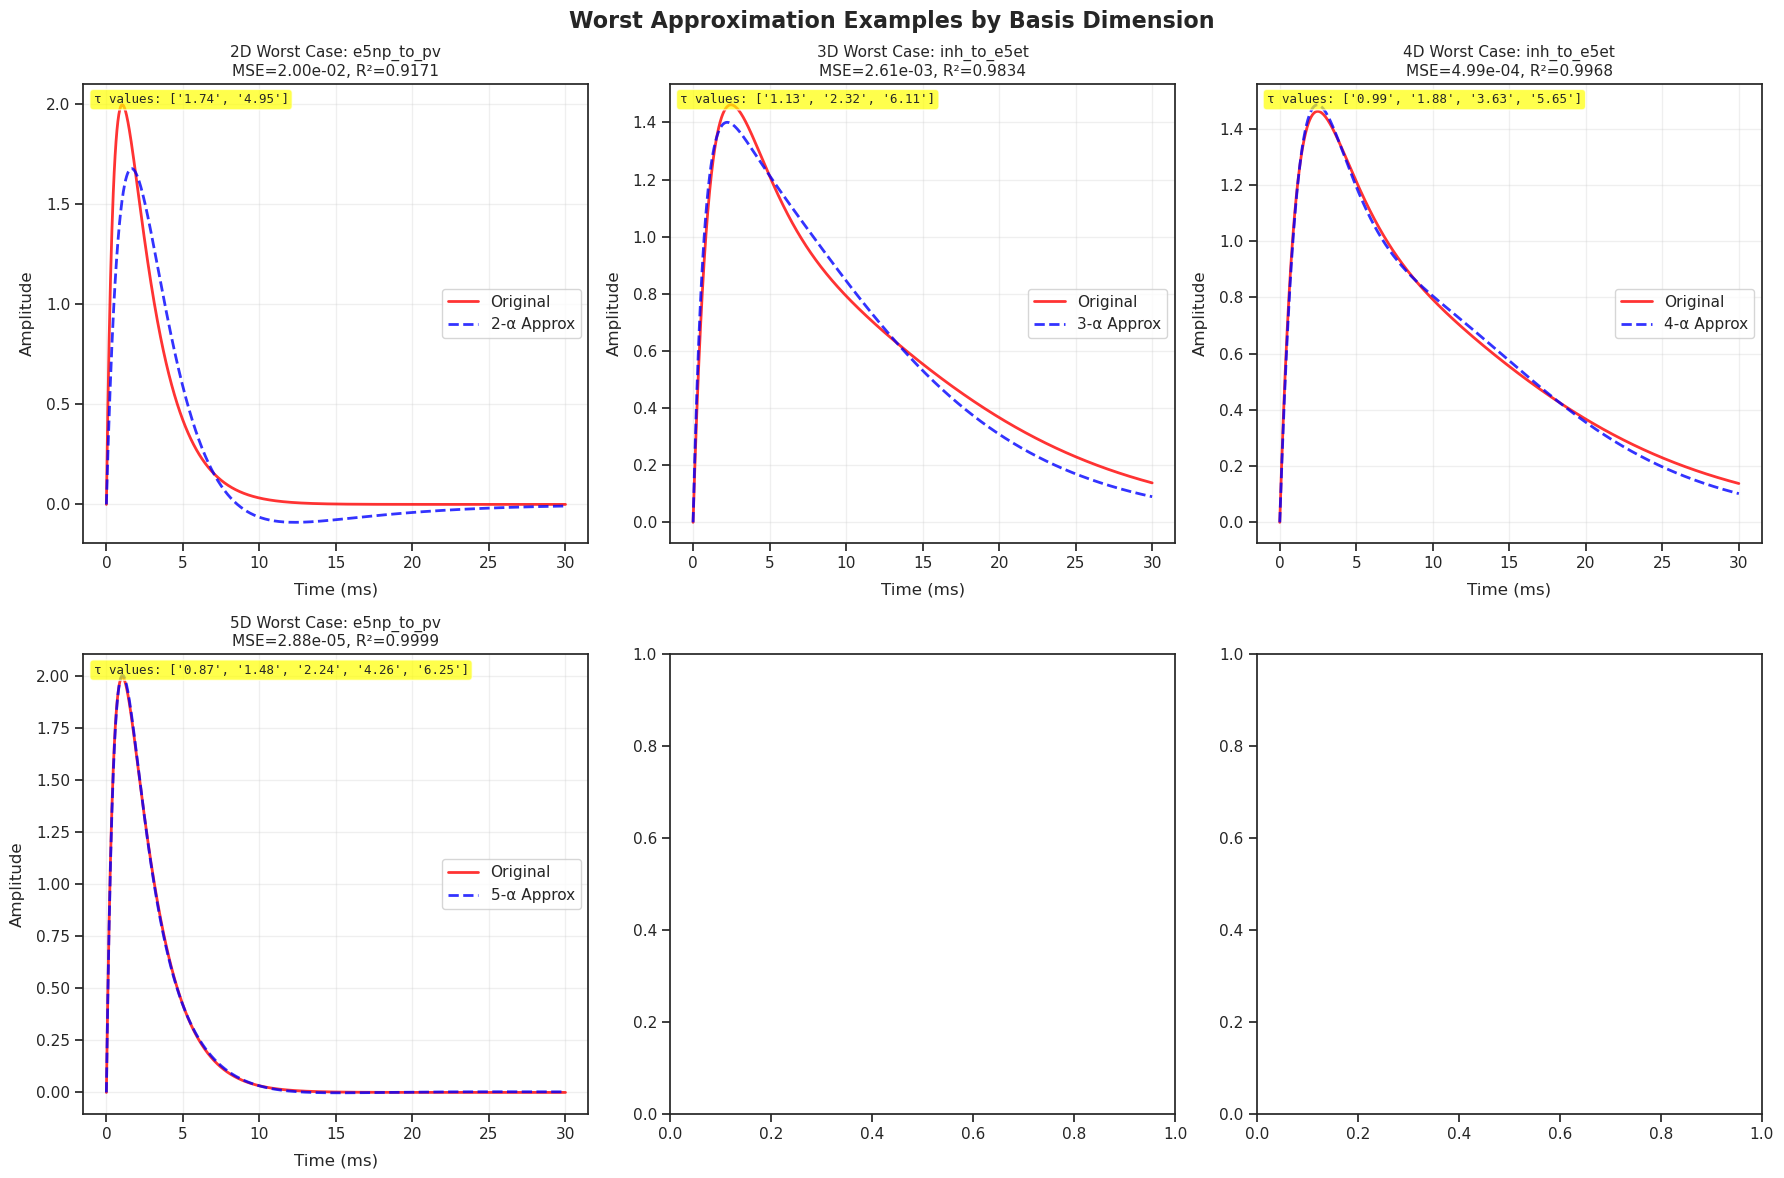

In [ ]:
def create_worst_examples_analysis(multi_dim_results, dimensions_to_test, all_functions, t, double_alpha_params):
    """
    Create figure showing worst approximation examples for each dimension.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, n_dims in enumerate(dimensions_to_test):
        ax = axes[i]
        result = multi_dim_results[n_dims]
        weights = result['weights']
        n_functions = len(all_functions)
        
        # Find worst case (highest MSE)
        worst_idx = np.argmax(result['mse_per_function'])
        worst_mse = result['mse_per_function'][worst_idx]
        
        # Get original function
        original_func = all_functions[worst_idx]
        
        # Compute approximation
        approx_func = basis_alpha_approximation(t, result['weights'][worst_idx], result['tau_basis'])
        
        # Plot
        ax.plot(t, original_func, linewidth=2, color='red', label='Original', alpha=0.8)
        ax.plot(t, approx_func, linewidth=2, color='blue', linestyle='--', 
                label=f'{n_dims}-α Approx', alpha=0.8)
        
        # Get connection name
        connection_name = double_alpha_params.iloc[worst_idx]['Unnamed: 0']
        
        # Calculate R²
        r2 = r2_score(original_func, approx_func)
        
        ax.set_title(f'{n_dims}D Worst Case: {connection_name}\n'
                    f'MSE={worst_mse:.2e}, R²={r2:.4f}', fontsize=11)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Amplitude')
        ax.legend(loc='center right')
        ax.grid(True, alpha=0.3)
        
        # Add tau values as text
        tau_text = f"τ values: {[f'{tau:.2f}' for tau in result['tau_basis']]}"
        ax.text(0.02, 0.98, tau_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.suptitle('Worst Approximation Examples by Basis Dimension', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig

print("\nCreating worst examples analysis...")
worst_examples_fig = create_worst_examples_analysis(enhanced_results, dimensions_to_test, 
                                                   all_functions, t, double_alpha_params)
plt.show()